## Dependências

In [97]:
!pip install seaborn
!pip install geopandas
!pip install folium
!pip install geopandas contextily matplotlib seaborn pyproj
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Testes e Validações

In [42]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

con.close()
con = duckdb.connect('dev.duckdb', read_only=True)

query = "SELECT * FROM main.stg_base_bruta_acidentes WHERE numero_boletim = '2021-009100344-001'"
df = con.execute(query).fetchdf()


pd.set_option('display.max_columns', None)


print(df.head(100))


       numero_boletim data_hora_boletim     data_inclusao tipo_acidente  \
0  2021-009100344-001  21/02/2021 17:02  21/02/2021 18:17        H08002   

                                  desc_tipo_acidente  cod_tempo  \
0  CHOQUE MECANICO COM VITIMA                    ...          4   

        desc_tempo  cod_pavimento        pavimento  cod_regional  \
0  NUBLADO                      1  ASFALTO                    23   

     desc_regional   origem_boletim local_sinalizado  velocidade_permitida  \
0  NORTE            POLICIA MILITAR              NÃO                    60   

   coordenada_x  coordenada_y hora_informada indicador_fatalidade  valor_ups  \
0     613674.04    7805466.31            SIM                  SIM          0   

   descricao_ups data_alteracao_smsa  valor_ups_antiga descricao_ups_antiga  
0  NÃO INFORMADO          00/00/0000                 0        NÃO INFORMADO  


In [43]:
con.close()

## Visualizações e Análises

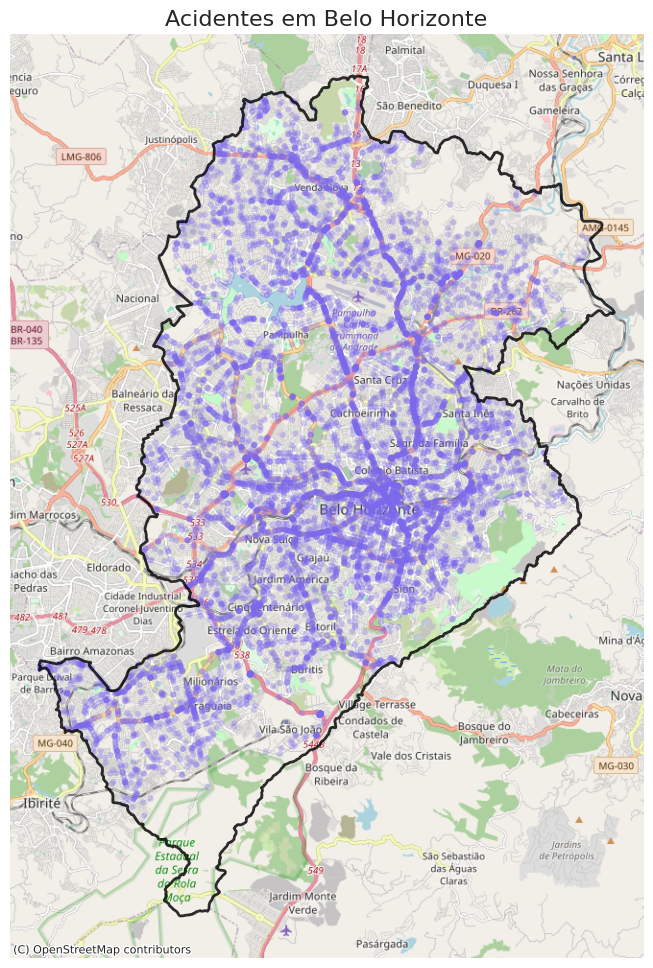

In [98]:
import duckdb
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from pyproj import Transformer

con = duckdb.connect('dev.duckdb', read_only=True)
query = """
SELECT longitude, latitude
FROM analise_geografica_acidentes
WHERE longitude IS NOT NULL AND latitude IS NOT NULL
"""
df = con.execute(query).fetchdf()
con.close()

transformer = Transformer.from_crs("EPSG:31983", "EPSG:4326", always_xy=True)
df[['lon', 'lat']] = df.apply(lambda row: pd.Series(transformer.transform(row['longitude'], row['latitude'])), axis=1)

bh_shape = gpd.read_file('limite_municipio.json')

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")

if bh_shape.crs != gdf.crs:
    bh_shape = bh_shape.to_crs(gdf.crs)

gdf_clip = gpd.sjoin(gdf, bh_shape, predicate='within')

gdf_clip = gdf_clip.to_crs(epsg=3857)
bh_shape = bh_shape.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))

xmin, ymin, xmax, ymax = bh_shape.total_bounds
margin_x = (xmax - xmin) * 0.05
margin_y = (ymax - ymin) * 0.05
ax.set_xlim(xmin - margin_x, xmax + margin_x)
ax.set_ylim(ymin - margin_y, ymax + margin_y)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.scatter(
    gdf_clip.geometry.x, gdf_clip.geometry.y,
    s=20,
    color='mediumslateblue',
    alpha=0.3,
    edgecolors='none'
)

bh_shape.boundary.plot(ax=ax, edgecolor='black', linewidth=2, alpha=0.8)

ax.set_axis_off()
plt.title('Acidentes em Belo Horizonte', fontsize=16)
plt.show()

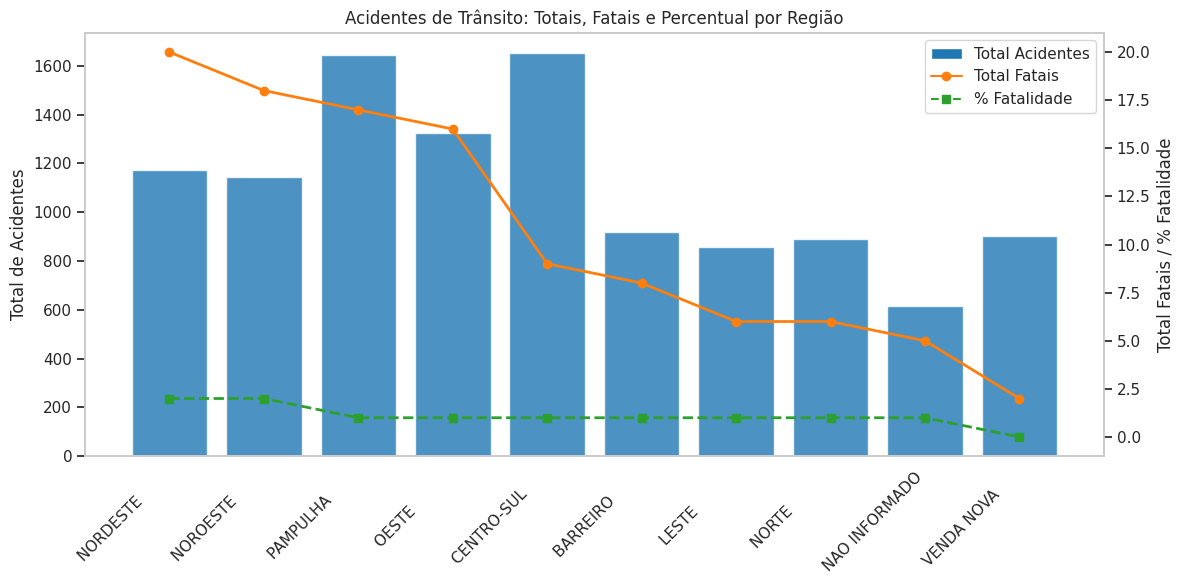

In [99]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


con = duckdb.connect('dev.duckdb', read_only=True)
query = """
SELECT *
FROM acidentes_fatalidade_regiao
"""
df = con.execute(query).fetchdf()
con.close()


fig, ax1 = plt.subplots(figsize=(12, 6))

positions = range(len(df))


bar_color = '#1f77b4'
bars = ax1.bar(positions, df['total_acidentes'], color=bar_color, alpha=0.8, label='Total Acidentes')


ax2 = ax1.twinx()


line1_color = '#ff7f0e'
line1 = ax2.plot(positions, df['total_fatais'], color=line1_color, marker='o', linewidth=2, label='Total Fatais')


line2_color = '#2ca02c'
line2 = ax2.plot(positions, df['pct_fatalidade'] * 100, color=line2_color, marker='s', linestyle='--', linewidth=2, label='% Fatalidade')


ax1.set_xticks(positions)
ax1.set_xticklabels(df['des_regional'], rotation=45, ha='right')


ax1.set_ylabel('Total de Acidentes')
ax2.set_ylabel('Total Fatais / % Fatalidade')
plt.title('Acidentes de Trânsito: Totais, Fatais e Percentual por Região')


ax1.grid(False)
ax2.grid(False)


legend_elements = [
    Patch(facecolor=bar_color, label='Total Acidentes'),
    Line2D([0], [0], color=line1_color, marker='o', label='Total Fatais'),
    Line2D([0], [0], color=line2_color, marker='s', linestyle='--', label='% Fatalidade')
]


ax1.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


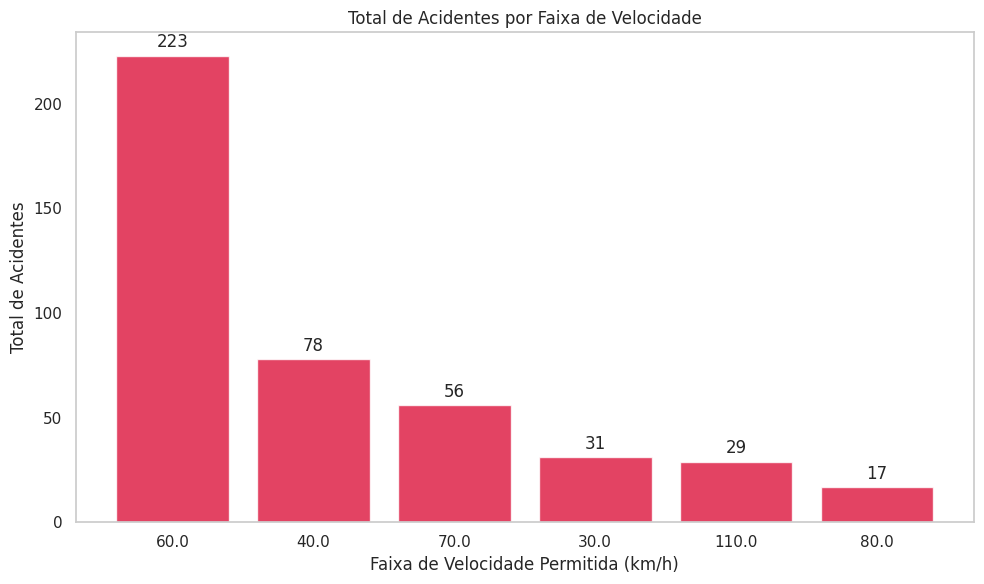

In [100]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt


con = duckdb.connect('dev.duckdb', read_only=True)
query = """
SELECT *
FROM acidentes_por_faixa_velocidade
WHERE faixa_velocidade <> 0
"""
df = con.execute(query).fetchdf()
con.close()


fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(df['faixa_velocidade'].astype(str), df['total_acidentes'], color='crimson', alpha=0.8)


for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')


ax.set_xlabel('Faixa de Velocidade Permitida (km/h)')
ax.set_ylabel('Total de Acidentes')
ax.set_title('Total de Acidentes por Faixa de Velocidade')


ax.grid(False)

plt.tight_layout()
plt.show()


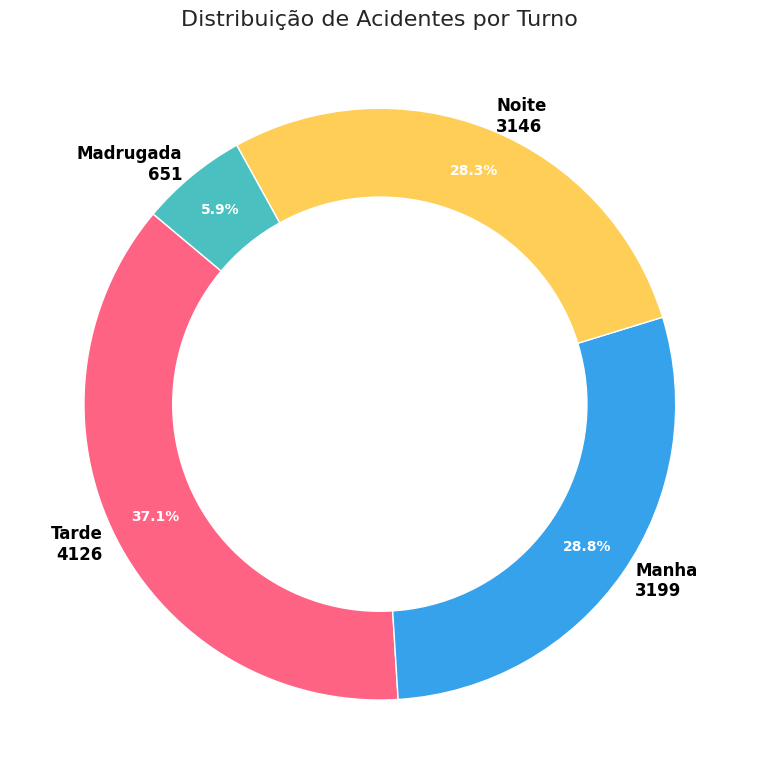

In [101]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt


con = duckdb.connect('dev.duckdb', read_only=True)
query = """
SELECT *
FROM acidentes_por_horario
"""
df = con.execute(query).fetchdf()
con.close()


colors = ['#FF6384', '#36A2EB', '#FFCE56', '#4BC0C0']


fig, ax = plt.subplots(figsize=(8, 8))


wedges, texts, autotexts = ax.pie(
    df['total_acidentes'],
    labels=df['turno'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops=dict(width=0.4),
    pctdistance=0.85,
    labeldistance=1.05
)


for i, row in df.iterrows():
    texts[i].set_text(f"{row['turno']}\n{row['total_acidentes']}")
    texts[i].set_color('black')  


plt.setp(autotexts, size=10, weight="bold", color="white")
plt.setp(texts, size=12, weight="bold")

ax.set_title('Distribuição de Acidentes por Turno', fontsize=16)

"donut"
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

plt.tight_layout()
plt.show()


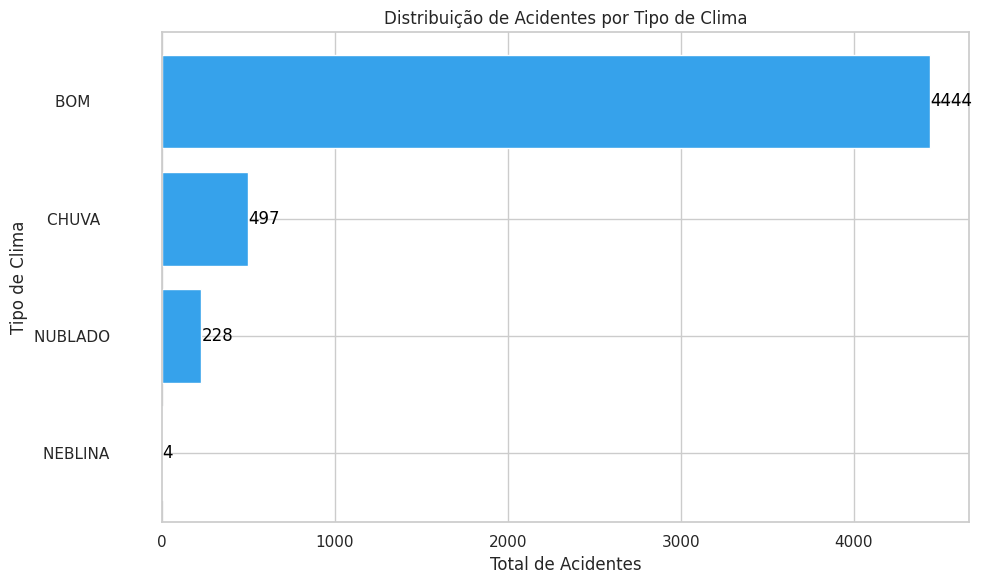

In [102]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt


con = duckdb.connect('dev.duckdb', read_only=True)
query = """
SELECT *
FROM acidentes_por_tipo_clima
WHERE TRIM(des_clima) <> 'NAO INFORMADO'
"""
df = con.execute(query).fetchdf()
con.close()


df_aggregated = df.groupby('des_clima')['total_acidentes'].sum().reset_index()


df_aggregated = df_aggregated.sort_values(by='total_acidentes', ascending=True)


fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(df_aggregated['des_clima'], df_aggregated['total_acidentes'], color='#36A2EB')


for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height() / 2,
            f'{int(width)}',
            ha='left', va='center', color='black')

ax.set_xlabel('Total de Acidentes')
ax.set_ylabel('Tipo de Clima')
ax.set_title('Distribuição de Acidentes por Tipo de Clima')

plt.tight_layout()
plt.show()


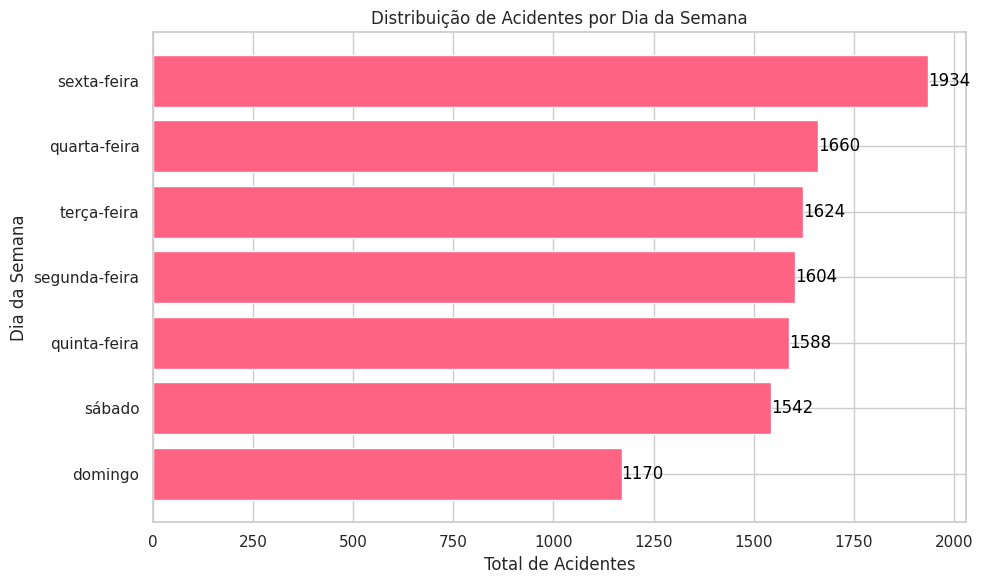

In [103]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt


con = duckdb.connect('dev.duckdb', read_only=True)
query = """
SELECT *
FROM acidentes_por_tipo_dia
"""
df = con.execute(query).fetchdf()
con.close()


df_aggregated = df.groupby('dia_semana_boletim')['total_acidentes'].sum().reset_index()


df_aggregated = df_aggregated.sort_values(by='total_acidentes', ascending=True)


fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(df_aggregated['dia_semana_boletim'], df_aggregated['total_acidentes'], color='#FF6384')


for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height() / 2,
            f'{int(width)}',
            ha='left', va='center', color='black')

ax.set_xlabel('Total de Acidentes')
ax.set_ylabel('Dia da Semana')
ax.set_title('Distribuição de Acidentes por Dia da Semana')

plt.tight_layout()
plt.show()


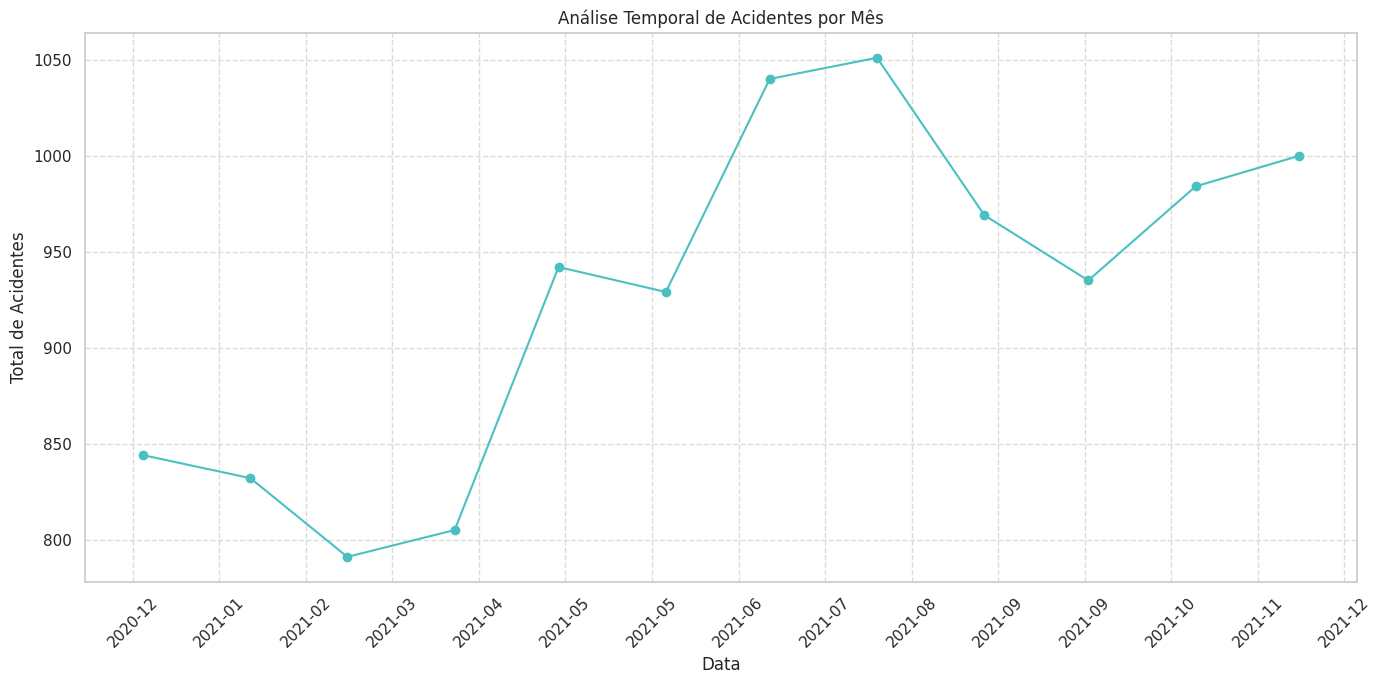

In [104]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt


con = duckdb.connect('dev.duckdb', read_only=True)
query = """
SELECT *
FROM analise_temporal_acidentes
"""
df = con.execute(query).fetchdf()
con.close()


df['data'] = pd.to_datetime(df['ano'].astype(str) + '-' + df['mes'].astype(str))


fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(df['data'], df['total_acidentes'], marker='o', linestyle='-', color='#4BC0C0')


ax.set_xlabel('Data')
ax.set_ylabel('Total de Acidentes')
ax.set_title('Análise Temporal de Acidentes por Mês')
plt.xticks(rotation=45)


ax.grid(True, linestyle='--', alpha=0.7)


ax.xaxis.set_major_locator(plt.MaxNLocator(15))
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()
